# Detection d'anomalie dans des séries temporelles
On utilise le modele de Facebook prophet qui a l'avantage d'être facile à utilser
D'après https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f



In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [3]:
#!pip install fbprophet

# Getting the data

In [6]:
from fbprophet import Prophet

In [11]:
#wget http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt

In [7]:
data = np.loadtxt("../data/dataset/sunspots.txt", float)

In [8]:
print(data.shape)

(3143, 2)


### Converting data to Pandas dataframe

In [9]:
# View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])

In [10]:
data_as_frame.head()

,Months,SunSpots
0,0.0,58.0
1,1.0,62.6
2,2.0,70.0
3,3.0,55.7
4,4.0,85.0


In [11]:
data_as_frame['ds']=data_as_frame['Months'].astype(int)

In [12]:
data_as_frame.head()

,Months,SunSpots,ds
0,0.0,58.0,0
1,1.0,62.6,1
2,2.0,70.0,2
3,3.0,55.7,3
4,4.0,85.0,4


### Converting the months column in format acceptable for Prophet, starting from 1749 

In [13]:
 data_as_frame['time_stamp']=data_as_frame.apply(lambda x:(pd.Timestamp('1749-01-01')+pd.DateOffset(months = int(x['ds']))),axis=1)

In [27]:
#Cleaning the df, we only need two columns date time and the data
clean_df=data_as_frame.drop(['Months','ds'],axis=1)

In [28]:
clean_df.head()

,SunSpots,time_stamp
0,58.0,1749-01-01
1,62.6,1749-02-01
2,70.0,1749-03-01
3,55.7,1749-04-01
4,85.0,1749-05-01


## Lets view the data in graphical format

Text(0.5, 1.0, 'Sunspots par mois')

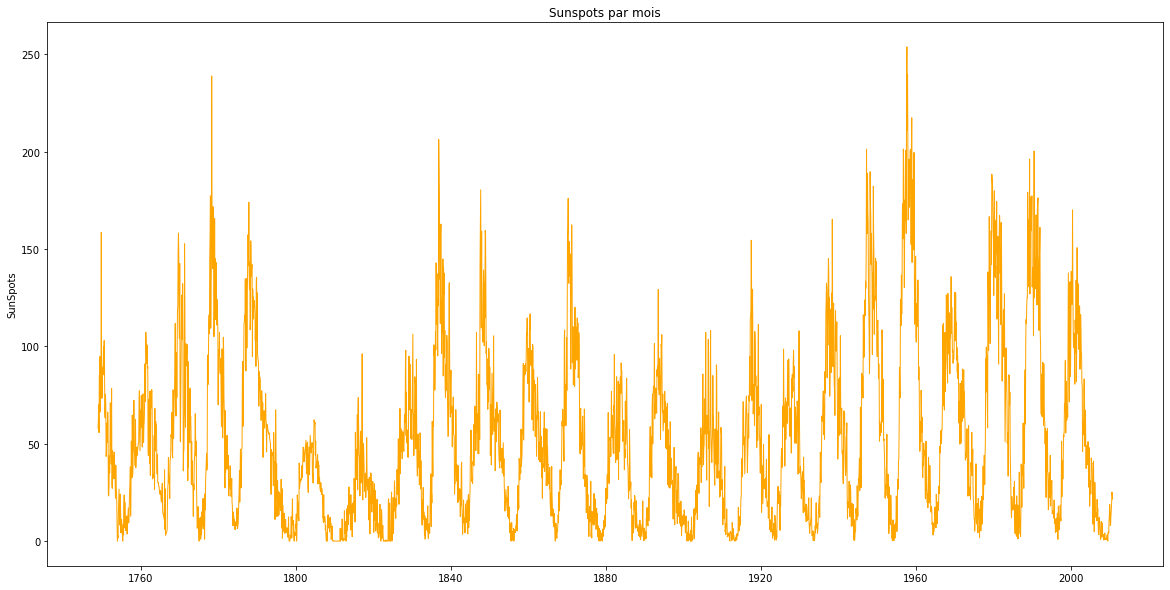

In [39]:
fig,ax=plt.subplots(figsize=(20, 10))
ax.set_ylabel('SunSpots')
data_as_frame=data_as_frame.set_index('time_stamp')
plt.plot(data_as_frame['SunSpots'], color='Orange',lw=1)
plt.title('Sunspots par mois')

# Preparing data for modelling in Prophet

In [31]:
## Prophet requires two columns, one is ds (the date time) and y (variable to be forecasted)
clean_df.columns = ['y', 'ds']

## Lets Predict

Displaying Prophet plot


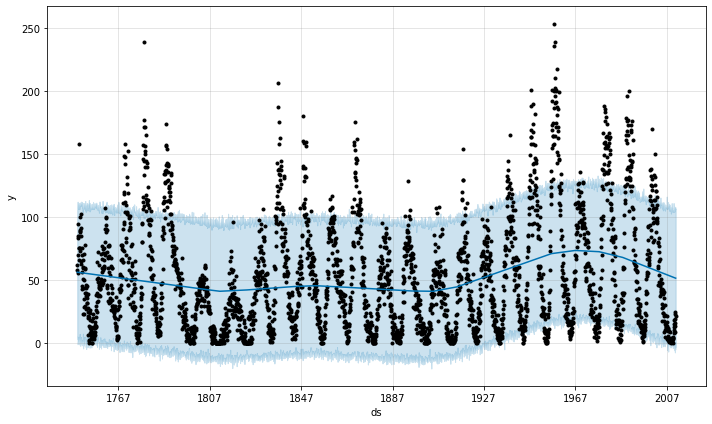

In [44]:
# deux hyper param à étalonner pour définir la largeur de la frontière  interval_width and changepoint_range
# si on baisse interval width on rétrécit la largeur

def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(clean_df)


# Detecting Anomalies:
* The light blue boundaries in the above graph are yhat_upper and yhat_lower.
* If y value is greater than yhat_upper and less than yhat lower then it is an anomaly.
* Also getting the importance of that anomaly based on its distance from yhat_upper and yhat_lower.

In [45]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [34]:
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,1749-01-01,57.445255,57.445255,-48.849108,165.635635,58.0,0,0.0
1,1749-02-01,57.421769,57.421769,-63.460306,160.754562,62.6,0,0.0
2,1749-03-01,57.400555,57.400555,-52.078186,168.947342,70.0,0,0.0
3,1749-04-01,57.377069,57.377069,-47.074016,160.800291,55.7,0,0.0
4,1749-05-01,57.354340,57.354340,-55.728302,167.746998,85.0,0,0.0


In [46]:
print(pred.anomaly.sum())
print(pred[pred.anomaly==1].head())

268
            ds      trend       yhat  yhat_lower  yhat_upper   fact  anomaly  \
10  1749-11-01  56.281006  56.281006    3.173447  110.528957  158.6        1   
239 1768-12-01  51.663588  51.663588   -1.507692  104.624186  111.8        1   
246 1769-07-01  51.523144  51.523144   -5.143492  104.773940  118.6        1   
247 1769-08-01  51.502608  51.502608   -1.046299  107.341061  120.3        1   
248 1769-09-01  51.482071  51.482071   -3.911601  103.050720  148.8        1   

     importance  
10     0.303096  
239    0.064184  
246    0.116577  
247    0.107722  
248    0.307455  
